In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import beam.calc.electron as ecalc
import scipy.constants as const
from beam.beams import electronbeam
from beam import interactions
plt.style.use('notes')
me = const.physical_constants['electron mass energy equivalent in MeV'][0]
e = const.physical_constants['elementary charge'][0]
path = 'Data/'

In [2]:
# Calculate beam evolution with no offset through a uniform plasma
Nz = 2000
z = np.linspace(0, 100*2*np.pi, Nz, dtype='double')
gb0 = 20000
ne0 = 2*gb0/5.95074e4**2 # Go from Robert units to normalized units
ne = ne0*np.ones(Nz)
kb = 5.95074e4 * np.sqrt(ne0)/np.sqrt(2*gb0)
betaBeam = 1
alphaBeam = 0
eps = 1.0e-6
delta = 0.02
sigma_r0 = np.sqrt(betaBeam*eps)
electronParams = {
    'name' : 'No_Offset',
    'path' : path,
    'load' : False,
    'N' : 50000,
    'gamma' : 20000,
    'emittance' : gb0*eps,
    'betax' : betaBeam,
    'betay' : betaBeam,
    'alphax' : alphaBeam,
    'alphay' : alphaBeam,
    'sigmaz' : 5e-6,
    'dE' : delta
}

beam = electronbeam.GaussianElectronBeam(electronParams)
#beam.plot_current_phase()

class plasmaCls():
    def __init__(self):
        """ Empy init function """
    def get_ne(self, z):
        return ne
    def dgammadz(self, ne):
        return 0.0
    
plasmaDen = plasmaCls()
dumpPer = 10
interactions.electron_plasma(beam, plasmaDen, z*1e6, dumpPer, 4)
beam_CS = beam.get_CS()
ptcl = beam.get_ptcl(0)

In [3]:
# There are two length scales in the problem: the betatron wavenumber and the beam size
# Betatron wavenumber should control the characteristic length of the emittance growth
# Beam size should control the length scale of the offset and saturated emittance
# Here we calculate the beam evolution for several different offsets.
offset = np.array([0.0, 0.1, 0.5, 1.0, 1.5, 2.0, 3.0, 5.0, 8.0, 10.0])
N = len(offset)
electronParams['offset_y'] = 0
electronParams['offset_xp'] = 0
electronParams['offset_yp'] = 0
beam_CS = {}
ptcls = {}
for i in range(N):
    electronParams['offset_x'] = offset[i]*sigma_r0
    electronParams['name'] = 'x-%0.2fsigmar0' % (offset[i])
    beam = electronbeam.OffsetGaussianElectronBeam(electronParams)
    interactions.electron_plasma(beam, plasmaDen, z*1e6, dumpPer, 4)
    beam_CS[i] = beam.get_CS()
    ptcls[i] = beam.load_ptcls(int(Nz/dumpPer))[0]

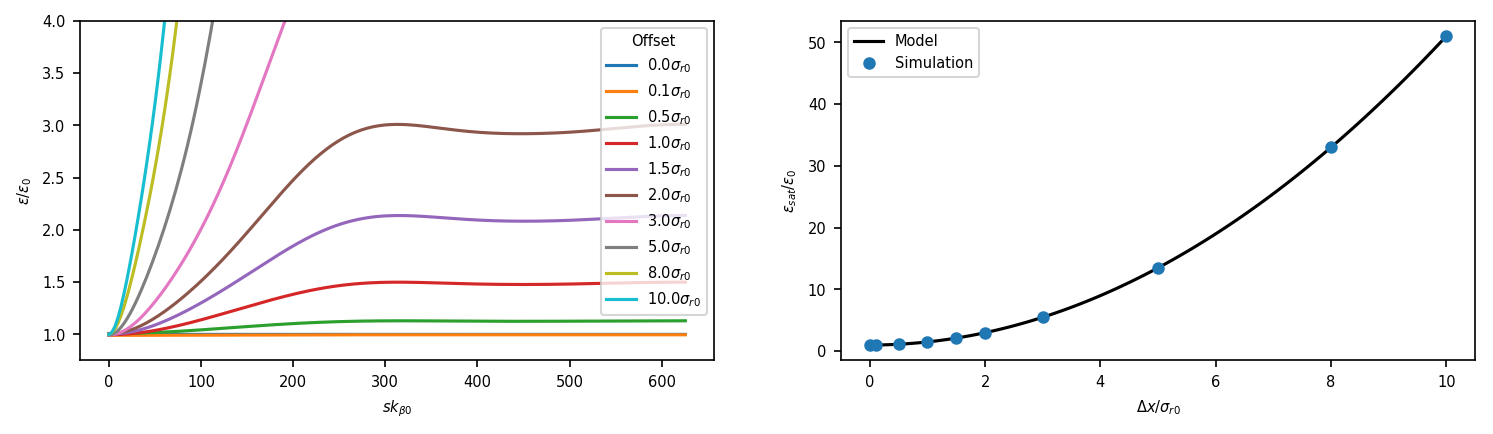

In [4]:
# Below is the emittance evolution for different offsets as well as the saturated emittance as a function of offset
# Conveniantly, it is obvious that the saturated emmitance is given by 1+1/2(off/sigma_r)^2
eps_sat = np.zeros(N)
plt.figure(figsize=(12, 3), dpi=150)
plt.subplot(121)
for i in range(N):
    eps_sat[i] = beam_CS[i]['eps_x'][-1]/eps
    plt.plot(beam.z, beam_CS[i]['eps_x']/eps, label=r'%0.1f$\sigma_{r0}$'%(offset[i]))
plt.legend(title=r'Offset')
plt.xlabel(r'$sk_{\beta0}$')
plt.ylabel(r'$\epsilon/\epsilon_0$')
plt.ylim(0.75, 4)
plt.subplot(122)
offset_model = np.linspace(0, 10, 100)
plt.plot(offset_model, 1+0.5*offset_model**2, 'k', label='Model')
plt.plot(offset, eps_sat, '.', markersize=10, label='Simulation')
plt.legend()
plt.xlabel(r'$\Delta x/\sigma_{r0}$')
plt.ylabel(r'$\epsilon_{sat}/\epsilon_0$')
plt.show()

/home/robert/anaconda3/envs/CU-PWFA/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in true_divide


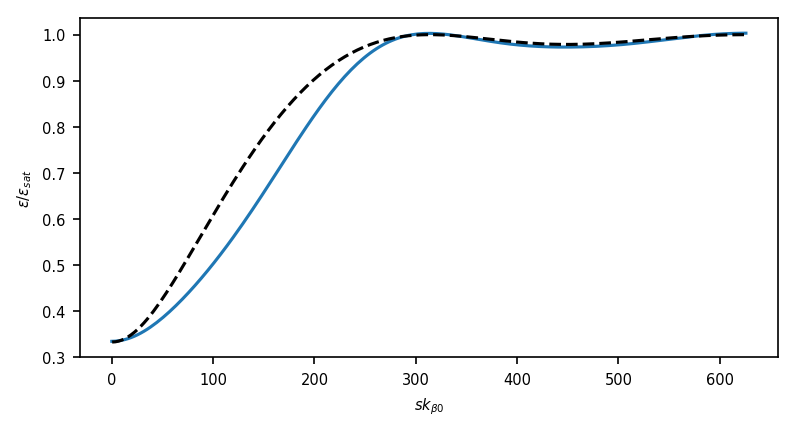

In [5]:
# The emittance growth is similar to that of a matched beam, but not exactly the same
# The phase factor seems correct but the functional dependence is incorrect
# The effect gets more noticable the larger the offset is
ind = 5
match_exp = 2 + offset[ind]**2
Psimax = beam.z/(np.sqrt(1-delta))
Psimin = beam.z/(np.sqrt(1+delta))
DeltaPsi = (Psimax-Psimin)/2
eps_theory = np.sqrt(1-(match_exp**2-4)/match_exp**2*(np.sin(DeltaPsi)/DeltaPsi)**2)

plt.figure(figsize=(6, 3), dpi=150)
plt.plot(beam.z, beam_CS[ind]['eps_x']/(1+0.5*offset[ind]**2)/eps)
plt.plot(beam.z, eps_theory, 'k--')
plt.xlabel(r'$sk_{\beta0}$')
plt.ylabel(r'$\epsilon/\epsilon_{sat}$')
#plt.ylim(0.75, 4)
plt.show()

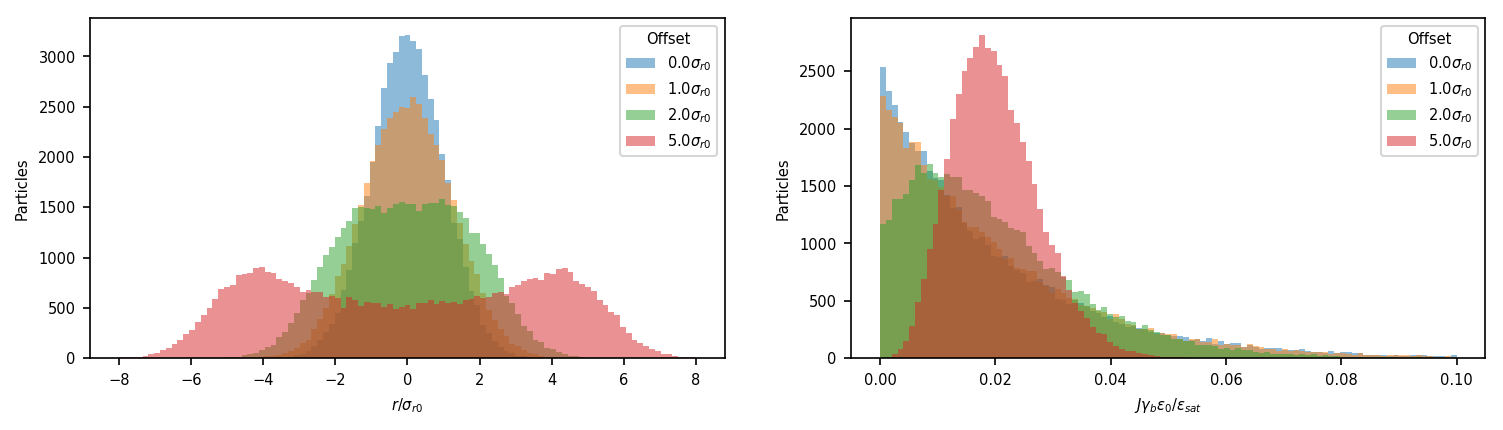

In [6]:
# The saturated beam distribution is given by the projection of the convolution of a Gaussian and a circle
# The distribution in action angle variables should approach an offset Gaussian
plt.figure(figsize=(12, 3), dpi=150)
plt.subplot(121)
bins = np.linspace(-8, 8, 100)
ind = [0, 3, 5, 7]
for i in ind:
    plt.hist(ptcls[i][:, 0]/sigma_r0, bins=bins, alpha=0.5, label=r'%0.1f$\sigma_{r0}$'%(offset[i]))
plt.legend(title=r'Offset')
plt.xlabel(r'$r/\sigma_{r0}$')
plt.ylabel('Particles')
plt.subplot(122)
for i in ind:
    ux = (ptcls[i][:, 0]-beam_CS[i]['cen_x'][-1])/np.sqrt(beam_CS[i]['beta_x'][-1])
    vx = ptcls[i][:, 1]*np.sqrt(beam_CS[i]['beta_x'][-1])+beam_CS[i]['alpha_x'][-1]*ux
    J = 0.5*(ux**2+vx**2)
    bins = np.linspace(0, 0.1, 100)
    plt.hist(J*gb0/eps_sat[i], bins=bins, alpha=0.5, label=r'%0.1f$\sigma_{r0}$'%(offset[i]))
plt.legend(title=r'Offset')
plt.xlabel(r'$J\gamma_b\epsilon_0/\epsilon_{sat}$')
plt.ylabel('Particles')
plt.show()
# The beam effectively travels on a different orbit than the reference particle
# The plot looks essentially the same for all of the different offsets, just scaled

In [7]:
# With the beam matched, sigma_x' should have the exact same effect
sigma_xp0 = np.sqrt(1/betaBeam*eps)
electronParams['offset_x'] = 0
electronParams['offset_y'] = 0
electronParams['offset_yp'] = 0
beam_CS = {}
ptcls = {}
for i in range(N):
    electronParams['offset_xp'] = offset[i]*sigma_xp0
    electronParams['name'] = 'xp-%0.2fsigmaxp0' % (offset[i])
    beam = electronbeam.OffsetGaussianElectronBeam(electronParams)
    interactions.electron_plasma(beam, plasmaDen, z*1e6, dumpPer, 4)
    beam_CS[i] = beam.get_CS()
    ptcls[i] = beam.load_ptcls(int(Nz/dumpPer))[0]

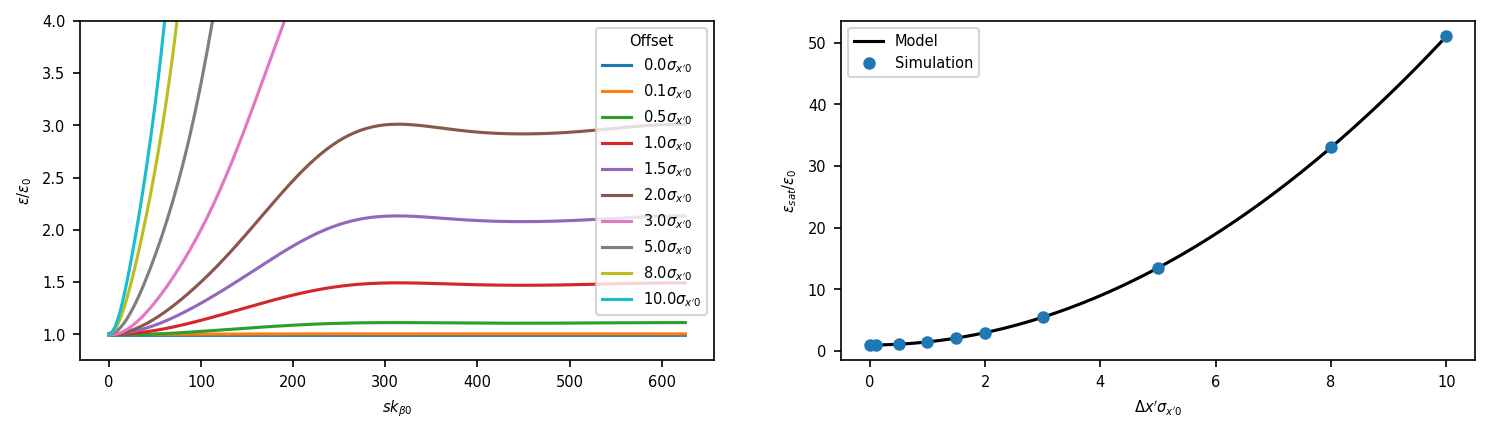

In [8]:
# As expected the emittance evolution is exactly the same
eps_sat = np.zeros(N)
plt.figure(figsize=(12, 3), dpi=150)
plt.subplot(121)
for i in range(N):
    eps_sat[i] = beam_CS[i]['eps_x'][-1]/eps
    plt.plot(beam.z, beam_CS[i]['eps_x']/eps, label=r"%0.1f$\sigma_{x'0}$"%(offset[i]))
plt.legend(title=r'Offset')
plt.xlabel(r'$sk_{\beta0}$')
plt.ylabel(r'$\epsilon/\epsilon_0$')
plt.ylim(0.75, 4)
plt.subplot(122)
offset_model = np.linspace(0, 10, 100)
plt.plot(offset_model, 1+0.5*offset_model**2, 'k', label='Model')
plt.plot(offset, eps_sat, '.', markersize=10, label='Simulation')
plt.legend()
plt.xlabel(r"$\Delta x'/\sigma_{x'0}$")
plt.ylabel(r'$\epsilon_{sat}/\epsilon_0$')
plt.show()

In [9]:
# The emittance growth is more difficult to extract when the beam is mismatched as well as offset
# At large offset (larger than the beam size) the offset should dominate the emittance growth,
# although the exact details will depend on the initial CS parameters
# At small offset the mismatch should dominate, expect them to approximatly add in quadrature
mismatch_b = np.array([1.0, 1.5, 2.0, 3.0, 4.0])
M = len(mismatch_b)
electronParams['offset_y'] = 0
electronParams['offset_xp'] = 0
electronParams['offset_yp'] = 0
beam_CS = {}
ptcls = {}
for i in range(M):
    beam_CS[i] = {}
    ptcls[i] = {}
    for j in range(N):
        electronParams['betax'] = mismatch_b[i]
        electronParams['betay'] = mismatch_b[i]
        sigma_x = np.sqrt(mismatch_b[i]*eps)
        electronParams['offset_x'] = offset[j]*sigma_r0
        electronParams['name'] = 'x-%0.2fsigmar0_b-%0.2fbetam' % (offset[j], mismatch_b[i])
        beam = electronbeam.OffsetGaussianElectronBeam(electronParams)
        interactions.electron_plasma(beam, plasmaDen, z*1e6, dumpPer, 4)
        beam_CS[i][j] = beam.get_CS()
        ptcls[i][j] = beam.load_ptcls(int(Nz/dumpPer))[0]

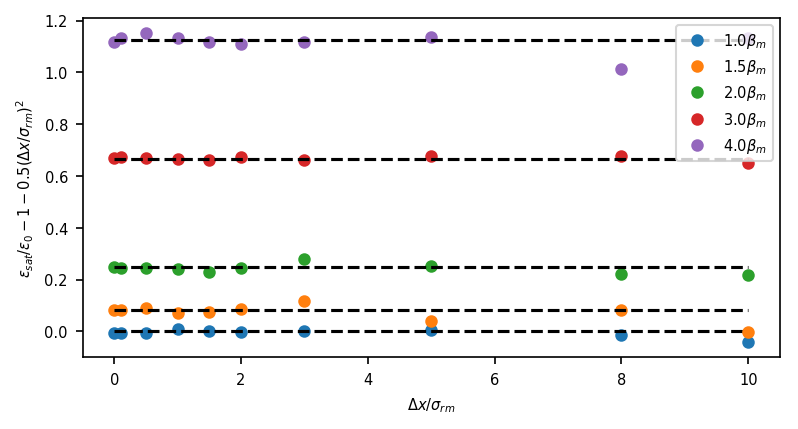

In [18]:
# You might think that the saturated emittance would be some complex function of offset and mismatch
# but instead it appears you just add the two together to get the emittance growth 
# however, the offset is measured as a function of the matched beams spot size
eps_sat = np.zeros((M, N))
plt.figure(figsize=(6, 3), dpi=150)
for i in range(M):
    for j in range(N):
        eps_sat[i, j] = beam_CS[i][j]['eps_x'][-1]/eps
    plt.plot(offset, eps_sat[i, :]-1-0.5*offset**2, '.', markersize=10, label=r'%0.1f$\beta_m$'%(mismatch_b[i]))
    eps_mis_sat = 0.5*(mismatch_b[i]+1/mismatch_b[i])-1
    plt.plot([0, 10], [eps_mis_sat, eps_mis_sat], 'k--')
offset_model = np.linspace(0, 10, 100)
#plt.plot(offset_model, 1+0.5*offset_model**2, 'k', label='Model')

plt.legend(loc=1)
plt.xlabel(r"$\Delta x/\sigma_{rm}$")
plt.ylabel(r'$\epsilon_{sat}/\epsilon_0-1-0.5(\Delta x/\sigma_{rm})^2$')
plt.show()